<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/Rule_based_method_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from tkinter.constants import NONE

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_excel("/content/sample_data/robust_test_dataset.xlsx")
# df_stuck_pipe = df[df["dataset"] == "stuck pipe"]
# df_pbu = df[df["dataset"] == "pressure build-up"]
# df_oil_shows = df[df["dataset"] == "oil shows"]
# df_gbearing = df[df["dataset"] == "gas bearing"]
df_fc = df[df["dataset"] == "fluid communication"]

df = df_fc

In [3]:
# Define the topics as flexible terms (subwords or whole words)
# topics = ["gas show" , "fluid communication" , "gas bearing" , "h2s" , "co2" , "stuck pipe" , "pressure build up"]
topics = ["fluid communication"]

# Define the negation terms pattern with case-insensitivity
negation_terms = r'(?i)(?:(?<=\s)|^)(no|non|unlikely|none|not|nor|without|lack|rather)(?=\s|$|\b)'

# Initialize a WordNet lemmatizer
# lemmatizer = WordNetLemmatizer()

# Define a custom lemmatization rule to replace "ized" with "e"
def custom_lemmatizer(word):
    if word.endswith("ized"):
        return re.sub(r'ized$', 'e', word)
    elif word.endswith("ing"):
        return re.sub(r'ing$', 'e', word)
    else:
        return word
        # return lemmatizer.lemmatize(word)

# Initialize a list to store selected sentences
selected_sentences = []

# Initialize a flag to check for both topic terms and negation terms
both_detected = False

# Iterate over the 'date' column and apply .lower() only to string values
for index, row in df.iterrows():
    if isinstance(row['doc_text_original'], str):
        # Apply .lower() to string values
        text = row['doc_text_original'].lower()  # Convert to lowercase

    # Tokenize the text into sentences using NLTK's sent_tokenize
    sentences = sent_tokenize(text)

    # Initialize flags to check for both topic terms and negation terms
    topic_found = False
    negation_detected = False

    for sentence in sentences:
      # Tokenize the sentence into words
      words = word_tokenize(sentence)

      # Lemmatize each word using the custom lemmatizer
      lemmatized_words = [custom_lemmatizer(word) for word in words]

      # Join the lemmatized words back into a sentence
      lemmatized_sentence = ' '.join(lemmatized_words)

      # Check if the sentence contains any of the specified topics (partial matches)
      for topic_pattern in topics:
        words = topic_pattern.split()

      if len(words) >= 2:
        # Initialize an empty pattern string
        pattern_string = r'(?i)(?:(?<=\s)|^)'

        # Loop through the words and add them to the pattern
        for i in range(len(words)):
            pattern_string += re.escape(words[i])

            # Add optional characters (like hyphens) between words (except for the last word)
            if i < len(words) - 1:
                pattern_string += r'\s*-*\s*'

        # Add the closing part of the pattern
        pattern_string += r'(?=\s|$)'

        # Compile the regex pattern
        topic_pattern = re.compile(pattern_string)

        if re.search(topic_pattern, lemmatized_sentence.lower()):
            topic_found = True
            break

        """
        if len(words) >= 2:
          # Define the regex pattern for two-word topics with optional characters in the middle
          two_word_topic_pattern = re.compile(rf'(?i)(?:(?<=\s)|^)({re.escape(words[0])}\s*-*\s*{re.escape(words[1])})(?=\s|$)')
          if re.search(two_word_topic_pattern, lemmatized_sentence.lower()):
            topic_found = True
            break
        """

      else:
          single_pattern = rf'(?i)(?:(?<=\s)|^)({re.escape(words[0])})(?=\s|$)'
          if re.search(single_pattern, lemmatized_sentence.lower()):
              topic_found = True
              break

      # Check if the lemmatized sentence contains negation terms
      if re.search(negation_terms, lemmatized_sentence.lower()):
          negation_detected = True
      else:
          negation_detected = False

      # If a topic term is found and either no negation terms are found or negation_detected is False, append the sentence
      if (topic_found is True) and (negation_detected is True):
          selected_sentences.append(lemmatized_sentence)
          both_detected = True
          break

      elif (topic_found is True) and (negation_detected is False):
          selected_sentences.append(lemmatized_sentence)
          both_detected = True
          break


    # If no sentence with both topic and negation terms is found, append the first sentence without a negation term
    if not both_detected or topic_found is False:
        selected_sentences.append(lemmatized_sentence)



 # Add the selected_sentences as a new column named 'selected_sentence'
df['selected_sentence'] = selected_sentences

print(len(selected_sentences))


10


In [4]:
# Determine the prediction (0 or 1) based on the presence of negation terms in selected_sentence
for index, row in df.iterrows():
    selected_sentence = row['selected_sentence']

    if selected_sentence is not None:
        # Check if the lemmatized sentence contains negation terms
        if re.search(negation_terms, selected_sentence.lower()):
            prediction = 0  # Negation terms found, set the prediction to 0
        else:
            prediction = 1  # No negation terms found, set the prediction to 1
    else:
        prediction = 0  # Handle the case where selected_sentence is None

    df.at[index, 'predicted'] = prediction

# Print the DataFrame with the 'label' column
df[['doc_text_original', 'selected_sentence', 'label_code', 'predicted']]

,doc_text_original,selected_sentence,label_code,predicted
1457,"'The expected hydrocarbon was oil, the well be...",good sand-to-sand contact and thus probable fl...,1,1.0
1458,"'The expected hydrocarbon was oil, the well be...",good sand-to-sand contact and thus probable fl...,1,1.0
1459,"'The expected hydrocarbon was oil, the well be...",good sand-to-sand contact and thus probable fl...,1,1.0
1460,'Ice melting temperatures are consistent with ...,the small range of salinity values may infer t...,0,0.0
1461,'2. Upper Permian delta-front sandstones of th...,"prior to drille , it was thought that fracture...",0,1.0
1462,'2. Upper Permian delta-front sandstones of th...,"prior to drille , it was thought that fracture...",0,1.0
1463,"'At 3710 m MDRT, a 7 bbls increase was seen in...",the pressure in pipe went to 2000 psi with no ...,1,0.0
1464,"'At 3710 m MDRT, a 7 bbls increase was seen in...",the pressure in pipe went to 2000 psi with no ...,1,0.0
1465,"'At 3710 m MDRT, a 7 bbls increase was seen in...",the pressure in pipe went to 2000 psi with no ...,1,0.0
1466,"'At 3710 m MDRT, a 7 bbls increase was seen in...",the pressure in pipe went to 2000 psi with no ...,1,0.0


In [5]:
# Assuming 'df' is your DataFrame
df.to_excel("dataset_os.xlsx", index=False)

## **Prediction Evaluation**

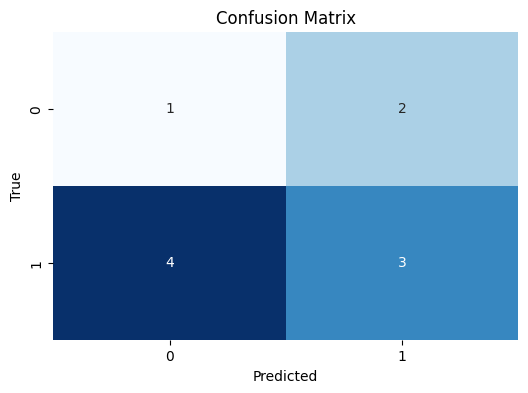

Accuracy: 0.40
Precision: 0.40
Recall: 0.38
F1 Score: 0.38


In [6]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
